In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def sinkhorn_knopp(a, b, M, reg, numItermax=1000,
                   stopThr=1e-9, verbose=False, log=False, **kwargs):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    M = np.asarray(M, dtype=np.float64)

    if len(a) == 0:
        a = np.ones((M.shape[0],), dtype=np.float64) / M.shape[0]
    if len(b) == 0:
        b = np.ones((M.shape[1],), dtype=np.float64) / M.shape[1]

    # init data
    dim_a = len(a)
    dim_b = len(b)

    if len(b.shape) > 1:
        n_hists = b.shape[1]
    else:
        n_hists = 0

    if log:
        log = {'err': []}

    # we assume that no distances are null except those of the diagonal of
    # distances
    if n_hists:
        u = np.ones((dim_a, n_hists)) / dim_a
        v = np.ones((dim_b, n_hists)) / dim_b
    else:
        u = np.ones(dim_a) / dim_a
        v = np.ones(dim_b) / dim_b

    # print(reg)

    # Next 3 lines equivalent to K= np.exp(-M/reg), but faster to compute
    K = np.empty(M.shape, dtype=M.dtype)
    np.divide(M, -reg, out=K)
    np.exp(K, out=K)

    # print(np.min(K))
    tmp2 = np.empty(b.shape, dtype=M.dtype)

    Kp = (1 / a).reshape(-1, 1) * K
    cpt = 0
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        KtransposeU = np.dot(K.T, u)
        v = np.divide(b, KtransposeU)
        u = 1. / np.dot(Kp, v)

        if (np.any(KtransposeU == 0)
                or np.any(np.isnan(u)) or np.any(np.isnan(v))
                or np.any(np.isinf(u)) or np.any(np.isinf(v))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Warning: numerical errors at iteration', cpt)
            u = uprev
            v = vprev
            break
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            if n_hists:
                np.einsum('ik,ij,jk->jk', u, K, v, out=tmp2)
            else:
                # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
                np.einsum('i,ij,j->j', u, K, v, out=tmp2)
            err = np.linalg.norm(tmp2 - b)  # violation of marginal
            if log:
                log['err'].append(err)

            if verbose:
                if cpt % 200 == 0:
                    print(
                        '{:5s}|{:12s}'.format('It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))
        cpt = cpt + 1
    if log:
        log['u'] = u
        log['v'] = v

    if n_hists:  # return only loss
        res = np.einsum('ik,ij,jk,ij->k', u, K, v, M)
        if log:
            return res, log
        else:
            return res

    else:  # return OT matrix

        if log:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1)), log
        else:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1))

In [127]:
class Wasserstein_Distance(nn.Module):

	def __init__(self, eps, max_iter, thresh=1e-5):

		super(Wasserstein_Distance, self).__init__()

		self.eps = eps
		self.max_iter = max_iter
		self.thresh = thresh


	def forward(self, x, y, p, q, cost_type='L2'):

		C = self._cost_matrix(x, y, cost_type)

		T, cost, a, b, K = self.forward_with_cost_matrix(C, p, q)

		return T, cost, a, b, K, C

	def forward_with_cost_matrix(self, C, p, q):

		K = torch.exp(- C / self.eps)
		#a = torch.zeros_like(p)
		b = torch.ones_like(q)

		for it in range(self.max_iter):
			a = p / (K @ b)

			b_old = b
			b = q / (K.T @ a)

			err = (b - b_old).abs().mean()

			if err < self.thresh:
				print('convergence by err')
				break

		T = torch.diag(a) @ K @ torch.diag(b)
		cost = (T * C).sum()

		return T, cost, a, b, K


	@staticmethod
	def _cost_matrix(x, y, cost_type='L2'):

		if cost_type == 'L2':
			x_col = x.unsqueeze(-2)
			y_lin = y.unsqueeze(-3)
			C = torch.sum((x_col - y_lin)**2, -1)

		else:
			raise NotImplementedError('cost type %s has not been implemented in Wasserstein_Distance _cost_matrix' %cost_type)

		return C


In [142]:
w_dist = Wasserstein_Distance(eps=20, max_iter=120, thresh=1e-5)
#w_dist = Wasserstein_Distance(eps=1e-1, max_iter=2000, device='cpu')

In [143]:
x = torch.randn((1000, 2)) * 10

y = x.clone() + 10
#y = x.clone() + 5

p_x = torch.ones(x.shape[0])
p_x /= p_x.sum()
p_x.shape

p_y = torch.ones(y.shape[0])
p_y /= p_y.sum()
p_y.shape

torch.Size([1000])

In [144]:
T, cost, a, b, K, C = w_dist(x, y, p_x, p_y)
#cost, T, _ = w_dist(x, y, p_x, p_y)

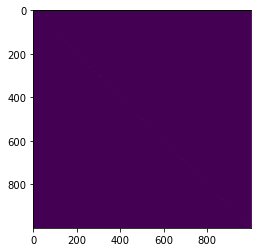

In [145]:
plt.imshow(T)

max_P:  torch.Size([1000, 1])


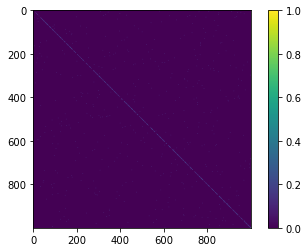

In [148]:
max_P, idx = torch.max(T, dim=1, keepdim=True)
print('max_P: ', max_P.shape)

X = (T>=max_P).int() #* 10

plt.imshow(X)
plt.colorbar()

In [101]:
X.int()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]], dtype=torch.int32)

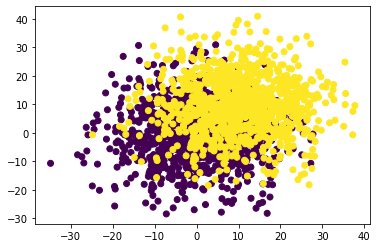

In [102]:
points = torch.cat((x,y), dim=0)
colors = torch.cat((torch.zeros(x.shape[0]), torch.ones(y.shape[0])), dim=0)

plt.scatter(points[:,0], points[:, 1], c=colors)

# compute Sinkhorn in log-domain for stabilization

In [25]:
# based on proposition 4.4, remark 4.21, 4.22, 4.23 of Computational Optimal Transport 
# (Chapter 4.4: Stability and Log-Domain Computations)

In [105]:
class Wasserstein_Distance(nn.Module):
    
    def __init__(self, eps, max_iter=500, thresh=1e-5):
        
        super(Wasserstein_Distance, self).__init__()
        
        self.eps = eps
        self.max_iter = max_iter
        self.thresh = thresh
    
    def forward(self, x, y, a, b, eps=None, max_iter=None, thresh=None):
        
        if eps:
            self.eps = eps
        if max_iter:
            self.max_iter = max_iter
        if thresh:
            self.thresh = thresh
        
        C = self._cost_matrix(x, y)
        
        return self.forward_with_cost_matrix(C, a, b)
    
    def forward_with_cost_matrix(self, C, a, b):
        
        f = torch.zeros_like(a)
        g = torch.zeros_like(b)
        
        for it in range(self.max_iter):
            f_old = f

            f = f + self.eps * (torch.log(a) - torch.logsumexp(self.S(C, f, g), dim=-1))
            g = g + self.eps * (torch.log(b) - torch.logsumexp(self.S(C, f, g).T, dim=-1))
            
            err = (f - f_old).abs().mean()
            if err < self.thresh:
                print('Break Sinkhorn alg at %s-th iteration by err convergence' %(it))
                break
        
        log_P = self.S(C, f, g)
                
        P = torch.exp(log_P)
        
        cost = (P * C).sum()
        
        return cost, P
    
    def S(self, C, f, g):
        """function S as in 4.43, 4.44"""
        return (- C + f.unsqueeze(-1) + g.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, cost_type='L2'):
        
        if cost_type == 'L2':
            #todo: this code require too much memory to compute cost matrix if the sample sizes of x and y is large -> need to re-implement
            x_col = x.unsqueeze(-2)
            y_lin = y.unsqueeze(-3)
            
            cost = torch.sum((x_col - y_lin)**2, dim=-1)
        else:
            raise NotImplementedError('The cost type %s has not been implemented yet' %(cost_type))
        
        return cost

In [122]:
w_dist = Wasserstein_Distance(eps=1, max_iter=1000, thresh=1e-5)


In [653]:
x = torch.randn((500, 2)) * 10
y = x.clone() + 10

#x = torch.tensor([[0, 0], [0, 2], [1, 0], [1, 1]]).float()
#y = x.clone() + 5

#x = torch.tensor([[i, 0*i + 1] for i in range(10)]).float()
#y = x.clone() + 5

noise = torch.randn(y.shape) * 2

p_x = torch.ones(x.shape[0])
p_x /= p_x.sum()

p_y = torch.ones(y.shape[0])
p_y /= p_y.sum()

In [123]:
cost, P = w_dist(x, y, p_x, p_y)
cost

tensor(196.8143)

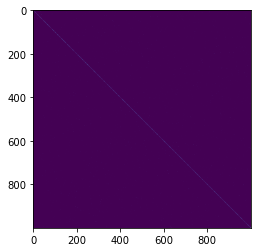

In [124]:
plt.imshow(P)

max_P:  torch.Size([1000, 1])


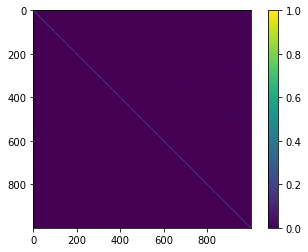

In [125]:
max_P, idx = torch.max(P, dim=1, keepdim=True)
print('max_P: ', max_P.shape)

X = (P>=max_P)

plt.imshow(X)
plt.colorbar()

In [656]:
C = cost_matrix(x, y)
P = sinkhorn_knopp(p_x.double(), p_y.double(), C.double(), 1.5)

(<matplotlib.image.AxesImage at 0x7fc46009ef50>,
 tensor(199.5968, dtype=torch.float64))

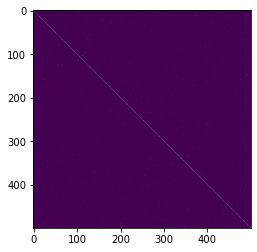

In [658]:
plt.imshow(P), torch.sum(torch.from_numpy(P) * C)

max_P:  torch.Size([500, 1])


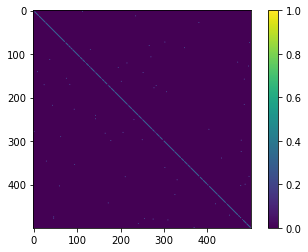

In [651]:
max_P, idx = torch.max(torch.from_numpy(P), dim=1, keepdim=True)
print('max_P: ', max_P.shape)

X = (torch.from_numpy(P)>=max_P)

plt.imshow(X)
plt.colorbar()

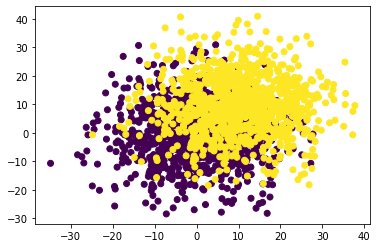

In [126]:
points = torch.cat((x,y), dim=0)
colors = torch.cat((torch.zeros(x.shape[0]), torch.ones(y.shape[0])), dim=0)

plt.scatter(points[:,0], points[:, 1], c=colors)

# Implement GW distance 

In [65]:
# based on Chapter 10.6.3 and 10.6.4 of Computational Optimal Transport

In [577]:
class GromovWasserstein_Distance(nn.Module):
    
    def __init__(self, eps, gw_max_iter, gw_thresh, w_max_iter, w_thresh):
        
        super(GromovWasserstein_Distance, self).__init__()
        
        self.eps = eps
        self.gw_max_iter = gw_max_iter
        self.gw_thresh = gw_thresh
        
        self.w_Distance = Wasserstein_Distance(eps, w_max_iter, w_thresh)
        
    def forward(self, x, y, p, q):
        
        Cx = self._intra_distance_matrix(x)
        Cy = self._intra_distance_matrix(y)
        
        return self.forward_with_cost_matrices(Cx, Cy, p, q)
    
    def forward_with_cost_matrices(self, Cx, Cy, p, q):
        
        n1, n2 = Cx.shape[0], Cy.shape[0]
        
        P = p.unsqueeze(-1) * q.unsqueeze(-2)
        
        Cxy = (Cx**2 @ p.reshape(-1, 1)).repeat((1, n2)) + (q.reshape(1, -1) @ (Cy ** 2).T).repeat((n1, 1))
        
        for it in range(self.gw_max_iter):
            P_old = P
            
            # This update scheme seems to works as well but not as good and stable as the other
            #C_it = - Cx @ P @ Cy           
            #_, P = self.w_Distance.forward_with_cost_matrix(C_it, p, q)
            
            L = Cxy - 2 * Cx @ P @ Cy.T
            L = 2*L            
            
            #_, P = self.w_Distance.forward_with_cost_matrix(L, p, q)
                        
            P = torch.from_numpy(sinkhorn_knopp(p, q, L, self.eps)).float()
                                    
            err = (P_old - P).abs().mean()
            
            if err < self.gw_thresh:
                print('Break GW iteration at %s-th iteration' %(it))
                break
                
            if it % 10 == 0:
                gw_cost = torch.sum(P * L)
                print('At %s-th iteration: err = %f gw_dist = %.5f' %(it, err, gw_cost))
        
        gw_cost = torch.sum(P * L)
        #gw_cost = None
        
        return gw_cost, P
    
    @staticmethod
    def _intra_distance_matrix(x, cost_type='L2'):
        if cost_type == 'L2':
            x_row = x.unsqueeze(-2)
            x_col = x.unsqueeze(-3)
            
            cost = torch.sum((x_row - x_col)**2, dim=-1)   
        else:
            raise NotImplementedError('The cost type %s has not been implemented yet' %(cost_type))
        
        return cost
        
        

In [546]:
x = torch.randn((1000, 2)) * 10
y = x.clone() + 100


#x = torch.tensor([[0, 0], [0, 2], [1, 0], [1, 1]]).float()
#y = x.clone() + 5

#x = torch.tensor([[i, 0*i + 1] for i in range(10)]).float()
#y = x.clone() + 5

noise = torch.randn(y.shape) * 2

p_x = torch.ones(x.shape[0])
p_x /= p_x.sum()

p_y = torch.ones(y.shape[0])
p_y /= p_y.sum()

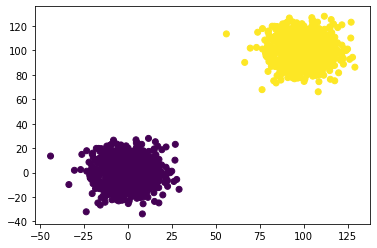

In [547]:
points = torch.cat((x,y), dim=0)
colors = torch.cat((torch.zeros(x.shape[0]), torch.ones(y.shape[0])), dim=0)

plt.scatter(points[:,0], points[:, 1], c=colors)

In [575]:
gw_dist = GromovWasserstein_Distance(eps=1e4, gw_max_iter=30, gw_thresh=1e-15,
                                    w_max_iter=2, w_thresh=1e-9)

In [576]:
gw_cost, P = gw_dist(x, y, p_x, p_y)

At 0-th iteration: err = 0.00000 gw_dist = 491921.68750
At 10-th iteration: err = 0.00000 gw_dist = 18054.68750
At 20-th iteration: err = 0.00000 gw_dist = 18054.70312


(<matplotlib.image.AxesImage at 0x7fc462350410>, tensor(18054.6992))

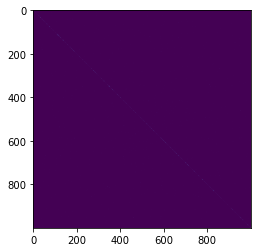

In [578]:
plt.imshow(P), gw_cost

max_P:  torch.Size([1000, 1])


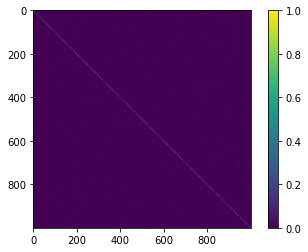

In [579]:
max_P, idx = torch.max(P, dim=1, keepdim=True)
print('max_P: ', max_P.shape)

X = (P>=max_P)

plt.imshow(X)
plt.colorbar()

In [556]:
P.sum(), P

(tensor(1.0000),
 tensor([[1.6190e-05, 1.5283e-08, 4.4641e-14,  ..., 1.1013e-13, 4.7446e-06,
          5.1744e-15],
         [1.5282e-08, 3.0685e-05, 4.3078e-23,  ..., 1.1715e-16, 9.5214e-07,
          7.7911e-24],
         [4.4625e-14, 4.3066e-23, 5.0278e-05,  ..., 1.6384e-13, 2.6634e-17,
          1.7976e-05],
         ...,
         [1.1011e-13, 1.1714e-16, 1.6387e-13,  ..., 6.8427e-05, 4.5352e-16,
          6.8879e-11],
         [4.7445e-06, 9.5220e-07, 2.6643e-17,  ..., 4.5358e-16, 1.7262e-05,
          1.2362e-18],
         [5.1728e-15, 7.7891e-24, 1.7976e-05,  ..., 6.8865e-11, 1.2358e-18,
          5.5643e-05]]))

In [204]:
import ot


In [7]:
ot.__version__

'0.7.0'

In [201]:
def cost_matrix(x, y):
    x_row = x.unsqueeze(-2)
    y_col = y.unsqueeze(-3)
    
    return torch.sum((x_row - y_col) ** 2, dim=-1)

In [178]:
x = torch.randn((100, 10)) * 10

y = x.clone() + 50

noise = torch.randn(y.shape)
y += noise * 3

p_x = torch.ones(x.shape[0])
p_x /= p_x.sum()

p_y = torch.ones(y.shape[0])
p_y /= p_y.sum()

In [59]:
y = x.clone() + 50
y = y.numpy()[::-1, :].copy()
y = torch.from_numpy(y)

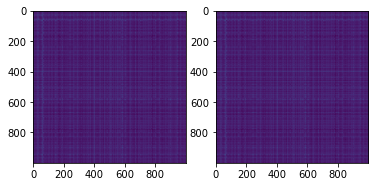

In [530]:
Cx = cost_matrix(x, x)
Cy = cost_matrix(y, y)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(Cx)
ax[1].imshow(Cy)

In [532]:
P = ot.gromov.entropic_gromov_wasserstein(Cx, Cy, p_x, p_y, loss_fun='square_loss', epsilon=1e4, max_iter=50, tol=1e-17, verbose=True)

It.  |Err         
-------------------
    0|2.472539e-03|
   10|6.017527e-08|
   20|9.780271e-10|
   30|1.589585e-11|
   40|2.583528e-13|


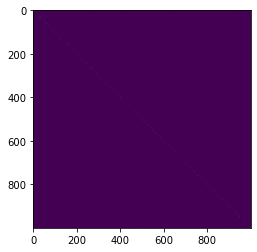

In [533]:
plt.imshow(P)

max_P:  torch.Size([1000, 1])


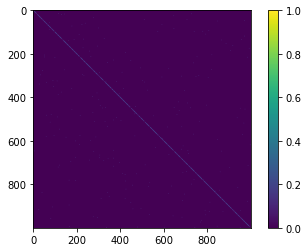

In [534]:
max_P, idx = torch.max(torch.from_numpy(P), dim=1, keepdim=True)
print('max_P: ', max_P.shape)

X = (torch.from_numpy(P)>=max_P)

plt.imshow(X)
plt.colorbar()

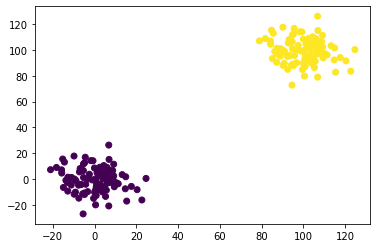

In [418]:
points = torch.cat((x,y), dim=0)
colors = torch.cat((torch.zeros(x.shape[0]), torch.ones(y.shape[0])), dim=0)

plt.scatter(points[:,0], points[:, 1], c=colors)